# Trajectory View

## Configurations

### Basics

In [5]:
from sys import stdout

import torch
import time
import json
import pprint
import random
import mdtraj
import nglview
import pandas
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from matplotlib import animation 
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

In [6]:
data_dir = "../data"
IMAGE_SIZE = "400px"

### Specific

In [21]:
molecule = "alanine"
state = "c7ax"
version = "24-11-14/14:08"
temperature = "1200.0"

In [22]:
result_dir = f"../log/{molecule}/{temperature}/{version}"
arg_file = f"{result_dir}/args.json"

with open(arg_file, 'r') as f:
	arg_data = json.load(f)
 
pprint.pprint(arg_data)

{'config': 'config/alanine/debug.json',
 'force_field': 'amber99',
 'freq_csv': 1,
 'freq_dcd': 1,
 'freq_stdout': 1000,
 'index': '0',
 'log_csv': True,
 'log_dcd': True,
 'log_force': False,
 'log_stdout': False,
 'molecule': 'alanine',
 'platform': 'OpenCL',
 'precision': 'mixed',
 'solvent': 'tip3p',
 'state': 'c5',
 'temperature': 1200.0,
 'time': 1000000}


## Ram chart

### By trajectory data

In [23]:
start = time.time()
print("Loading trajectory...")
traj_ad = mdtraj.load(
    f"{result_dir}/traj.dcd",
    top=f"{data_dir}/alanine/{state}.pdb"
)
end = time.time()
print(f"<--- {end-start} seconds --->")

Loading trajectory...
<--- 1.608187198638916 seconds --->


In [24]:
traj_ad.superpose(traj_ad, 0)
nglview.show_mdtraj(traj_ad, width=IMAGE_SIZE, height=IMAGE_SIZE)

NGLWidget(max_frame=999999)

In [25]:
def generate_color_codes(n):
    # Generate n evenly spaced integers between 0 and 0xFFFFFF (hexadecimal for 16777215)
    color_codes = [f'#{i:06X}' for i in range(0, 0xFFFFFF, 0xFFFFFF // (n-1))] if n > 1 else ['000000']
    return color_codes

In [26]:
def plot_ramachandran(traj, phi_start=None, psi_start=None):
    from matplotlib.gridspec import GridSpec

    phis = mdtraj.compute_phi(traj)[1].ravel()
    psis = mdtraj.compute_psi(traj)[1].ravel()

    fig = plt.figure()
    gs = GridSpec(nrows=3, ncols=3)
    length = traj.n_frames
    colors = generate_color_codes(length)[:length]
    
    # Ramachandran plot
    ax1 = fig.add_subplot(gs[:2, :2])
    # ax1.scatter(phi_start * 180 / np.pi, psi_start * 180 / np.pi, s=20, color="red", zorder=2)
    # ax1.hist2d(phis * 180 / np.pi, psis * 180 / np.pi, 100, norm=LogNorm(), zorder=1)
    ax1.scatter(phis * 180 / np.pi, psis * 180 / np.pi, s=1, color=colors, zorder=1)
    # ax1.scatter(phis[0] * 180 / np.pi, psis[0] * 180 / np.pi, s=2, color="red", zorder=2)
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")
    
    # Phi(t) plot
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.hist2d(np.arange(len(phis)), phis * 180 / np.pi, 100, norm=LogNorm(), zorder=1)
    ax2.axhline(0)
    ax2.set_ylim(-180, 180)
    ax2.set_yticks(np.linspace(-180, 180, 5))
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Phi [deg]")
    
    # Psi(t) plot
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.hist2d(np.arange(len(phis)), psis * 180 / np.pi, 100, norm=LogNorm(), zorder=1)
    ax3.axhline(0)
    ax3.set_ylim(-180, 180)
    ax3.set_yticks(np.linspace(-180, 180, 5))
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Psi [deg]")

    fig.tight_layout()

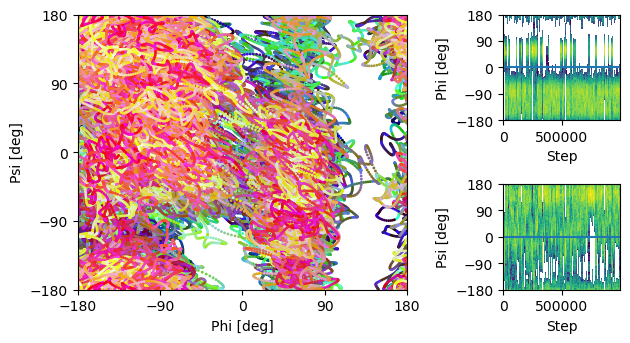

In [27]:
start_idx = 1230
plot_ramachandran(
    traj_ad
)

### By data 

In [90]:
class AlaninePotential():
    def __init__(self, landscape_path):
        super().__init__()
        self.open_file(landscape_path)

    def open_file(self, landscape_path):
        with open(landscape_path) as f:
            lines = f.readlines()

        dims = [90, 90]

        self.locations = torch.zeros((int(dims[0]), int(dims[1]), 2))
        self.data = torch.zeros((int(dims[0]), int(dims[1])))

        i = 0
        for line in lines[1:]:
            splits = line[0:-1].split(" ")
            vals = [y for y in splits if y != '']

            x = float(vals[0])
            y = float(vals[1])
            val = float(vals[-1])

            self.locations[i // 90, i % 90, :] = torch.tensor(np.array([x, y]))
            self.data[i // 90, i % 90] = (val)  # / 503.)
            i = i + 1

    def potential(self, inp):
        loc = self.locations.view(-1, 2)
        distances = torch.cdist(inp, loc.double(), p=2)
        index = distances.argmin(dim=1)

        x = torch.div(index, self.locations.shape[0], rounding_mode='trunc')  # index // self.locations.shape[0]
        y = index % self.locations.shape[0]

        z = self.data[x, y]
        return z

    def drift(self, inp):
        loc = self.locations.view(-1, 2)
        distances = torch.cdist(inp[:, :2].double(), loc.double(), p=2)
        index = distances.argsort(dim=1)[:, :3]

        x = index // self.locations.shape[0]
        y = index % self.locations.shape[0]

        dims = torch.stack([x, y], 2)

        min = dims.argmin(dim=1)
        max = dims.argmax(dim=1)

        min_x = min[:, 0]
        min_y = min[:, 1]
        max_x = max[:, 0]
        max_y = max[:, 1]

        min_x_dim = dims[range(dims.shape[0]), min_x, :]
        min_y_dim = dims[range(dims.shape[0]), min_y, :]
        max_x_dim = dims[range(dims.shape[0]), max_x, :]
        max_y_dim = dims[range(dims.shape[0]), max_y, :]

        min_x_val = self.data[min_x_dim[:, 0], min_x_dim[:, 1]]
        min_y_val = self.data[min_y_dim[:, 0], min_y_dim[:, 1]]
        max_x_val = self.data[max_x_dim[:, 0], max_x_dim[:, 1]]
        max_y_val = self.data[max_y_dim[:, 0], max_y_dim[:, 1]]

        grad = -1 * torch.stack([max_y_val - min_y_val, max_x_val - min_x_val], dim=1)

        return grad
    
    

In [118]:
landscape_path = f"../data/doobs.dat"
ad_potential = AlaninePotential(landscape_path)

In [119]:
def plot_ad_potential(potential, traj):  
    plt.clf()
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    phis = mdtraj.compute_phi(traj)[1].ravel()
    psis = mdtraj.compute_psi(traj)[1].ravel()

    xs = np.arange(-np.pi, np.pi + 0.1, 0.1)
    ys = np.arange(-np.pi, np.pi + 0.1, 0.1)
    x, y = np.meshgrid(xs, ys)
    inp = torch.tensor(np.array([x, y])).view(2, -1).T

    z = potential.potential(inp)
    z = z.view(y.shape[0], y.shape[1])
    plt.contourf(xs, ys, z, levels=100, zorder=0)

    # Plot the trajectory
    cm = plt.get_cmap("gist_rainbow")
    for idx in range(phis.shape[0]):
        ax.plot(
            phis,
            psis,
            marker="o",
            linestyle="None",
            markersize=4,
            alpha=1.0,
            zorder=101
        )
    
    # Plot the Ramachandran plot
    plt.xlim([-np.pi, np.pi])
    plt.ylim([-np.pi, np.pi])
    plt.xlabel("phi")
    plt.ylabel("psi")
    
    return 

<Figure size 640x480 with 0 Axes>

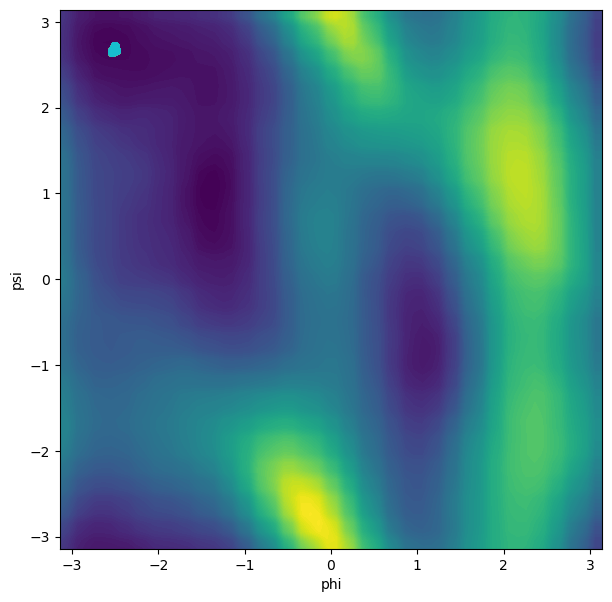

In [120]:
plot_ad_potential(ad_potential, traj_ad)

## Potential energy

<Axes: xlabel='#"Time (ps)"'>

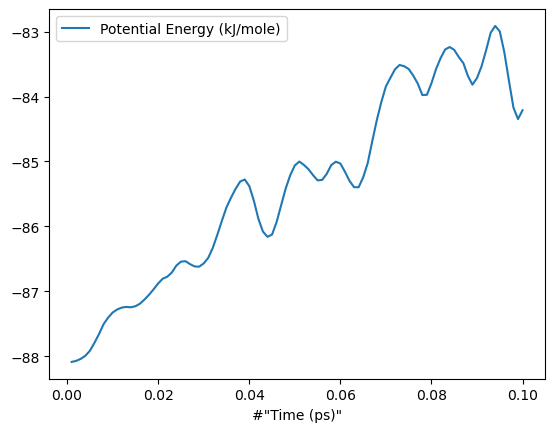

In [121]:
df1 = pandas.read_csv(f"{result_dir}/scalars.csv")
df1.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)")